In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn import preprocessing
from sklearn.cluster import KMeans
sns.set(rc={'figure.figsize':(18, 3)})

In [8]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pd.set_option('display.float_format', lambda x: x)
# pd.reset_option('^display.', silent=True)

## Using preprocessed datasets

In [247]:
crops_clean = pd.read_csv('datasets_cleaned/crops_cleaned.csv')
all_countries = pd.read_csv('datasets_cleaned/all_countries.csv')
crop_groups = pd.read_csv('datasets_cleaned/crop_groups.csv')
prices_clean = pd.read_csv('datasets_cleaned/producer_prices_cleaned.csv')
caffeine_prices_clean = pd.read_csv('datasets_cleaned/caffeine_prices_clean.csv')
rainfall = pd.read_csv('datasets_cleaned/rainfall_clean.csv')
temperatures = pd.read_csv('datasets_cleaned/temperatures_clean.csv')
gdp_data = pd.read_csv('datasets_cleaned/gdp_data.csv')

# merged data reads here!!!
yield_melted = pd.read_csv('datasets_cleaned/yield_melted.csv')
prod_melted = pd.read_csv('datasets_cleaned/prod_melted.csv')
areaHarv_melted = pd.read_csv('datasets_cleaned/areaHarv_melted.csv')
prices_melted = pd.read_csv('datasets_cleaned/prices_melted.csv')
climate_melted = pd.read_csv('datasets_cleaned/climate_melted.csv')
country_gdp_melted = pd.read_csv('datasets_cleaned/country_gdp_melted.csv')

# Data Modeling

## Clustering

In [91]:
rawMeltedYield = yield_melted.groupby(['Year', 'Area'])['Yield'].mean().reset_index()
rawMeltedProduction = prod_melted.groupby(['Year', 'Area'])['Production'].sum().reset_index()

### *...some messing around...*

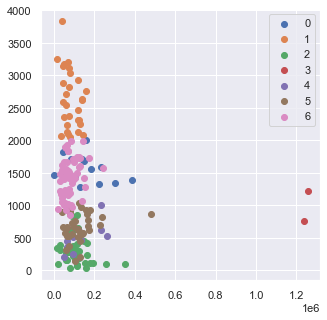

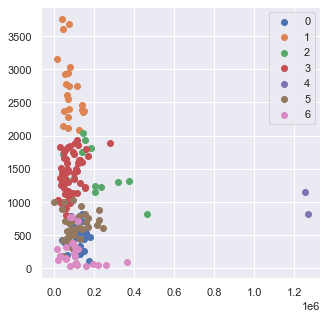

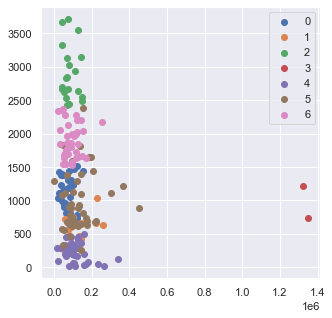

In [89]:
years = [2014, 2015, 2016]
for year in years:
    yield_temp = rawMeltedYield[rawMeltedYield['Year'] == year]
    climate_temp = climate_melted[climate_melted['Year'] == year]
    yield_climate_temp = pd.merge(yield_temp, climate_temp, on=['Year', 'Area'], how ='inner')
    X = yield_climate_temp[['Yield', 'Rainfall - (MM)', 'Temperature - (Celsius)']].copy()
    
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = KMeans(7, verbose=0)
    label = model.fit_predict(X_scaled)
    X.loc[:,'label'] = pd.Series(label)
    
    #Getting unique labels
    u_labels = np.unique(label)

    #plotting the results:
    plt.figure(figsize=(5,5))
    for i in u_labels:
        plt.scatter(X.iloc[label == i, 0] , X.iloc[label == i, 1] , label = i)
    plt.legend()
    plt.show()

### Merging Yield and climate data ...

In [268]:
# melted yield data without 'Items'
yield_toMerge = yield_melted.groupby(['Year', 'Area'])['Yield'].mean().reset_index()

# merging country yield and climate data
yield_and_climate = pd.merge(yield_toMerge, climate_melted, on=['Year', 'Area'], how='inner')

yield_and_climate

,Year,Area,Yield,Rainfall - (MM),Temperature - (Celsius)
0,1991,Afghanistan,55789.14583,435.44990,12.89449
1,1991,Albania,72175.01389,917.86880,11.03765
2,1991,Algeria,39498.31944,88.13276,22.51346
3,1991,Angola,40565.00000,1017.98660,21.71688
4,1991,Antigua and Barbuda,49817.48485,2151.03100,26.08025
...,...,...,...,...,...
4909,2016,Venezuela (Bolivarian Republic of),127677.08571,1844.70330,26.47820
4910,2016,Viet Nam,98377.59615,1988.86180,25.07316
4911,2016,Yemen,62133.75758,171.48137,24.22120
4912,2016,Zambia,85609.76923,803.47810,22.73705


### Question: *What can be made of clusters seen from annual total production vs GDP over time?*

### Merging production and GDP data ...

In [269]:
# melted production data without 'Items'
prod_toMerge = prod_melted.groupby(['Year', 'Area'])['Production'].sum().reset_index()

# only countries
prod_toMerge = prod_toMerge[prod_toMerge['Area'].isin(all_countries['0'])] 

# merging product and gdp data
prod_and_gdp = pd.merge(prod_toMerge, country_gdp_melted, on=['Year', 'Area'], how='inner')

prod_and_gdp

,Year,Area,Production,Gross Domestic Product
0,1990,Afghanistan,8827277.00000,3621.60001
1,1990,Albania,3609949.00000,2145.77452
2,1990,Algeria,10952838.00000,61751.37596
3,1990,Angola,6708679.00000,13661.85235
4,1990,Antigua and Barbuda,22864.00000,459.47037
...,...,...,...,...
5969,2018,Viet Nam,253898848.00000,244901.10410
5970,2018,Yemen,4986815.00000,26671.57950
5971,2018,Yugoslav SFR,0.00000,1563047.95919
5972,2018,Zambia,19756945.00000,27282.85451


## Total Production vs GDP, finding clusters of countries for each year

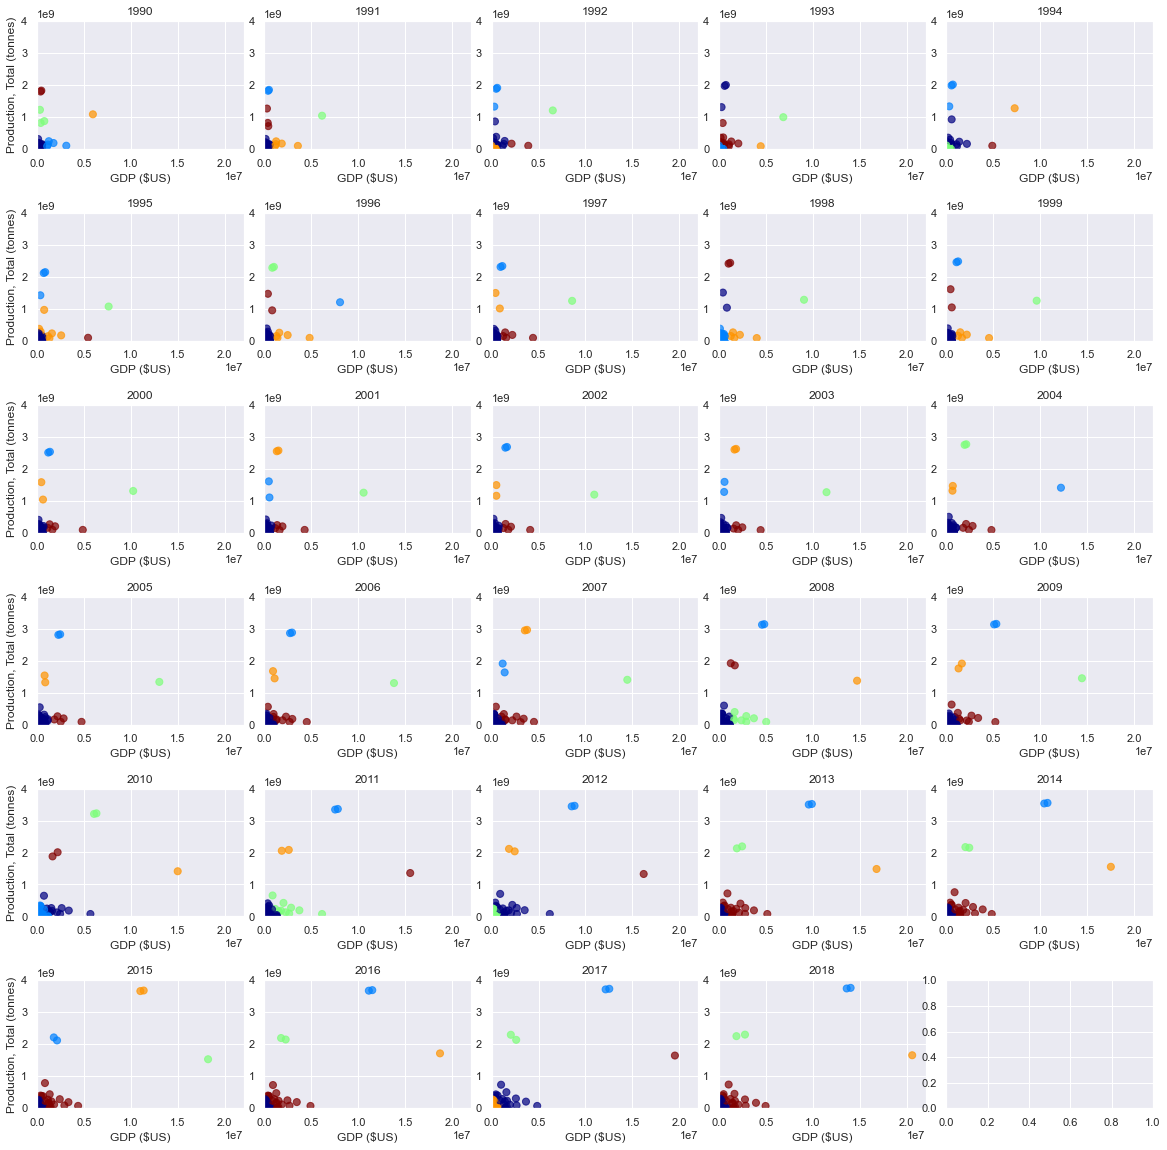

In [270]:
fig, axes = plt.subplots(6,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

grid_combos = []
for i in range(6):
    for j in range(5):
        grid_combos.append((i, j))
        
# from the years ?
years = [year for year in range(1990, 2019)]
        
for i, year in enumerate(years):
    # taking country total production and gdp for this year
    year_filter = (prod_and_gdp['Year'] == year)
    prod_and_gdp2 = prod_and_gdp.loc[year_filter, ['Year', 'Area', 'Production', 'Gross Domestic Product']]

    # scaling the numerical values
    scaler = preprocessing.MinMaxScaler() # min-max normalizer
    X = prod_and_gdp2[['Production', 'Gross Domestic Product']] # numeric values only
    X_scaled = X.copy()
    X_scaled[['Production', 'Gross Domestic Product']] = scaler.fit_transform(X) # scaling numerics
    
    # kmeans clustering
    model = KMeans(5, verbose=0) # fitting for 5 clusters
    model.fit(X_scaled)
    X_scaled['kmeans'] = model.labels_
    kmeans_labels = pd.Series(model.labels_)
    v1 = X['Gross Domestic Product']
    v2 = X['Production']
    
    # drawing scatterplot for this year
    row, col = grid_combos[i]
    axes[row, col].scatter(v1, v2, c = kmeans_labels, s=50, cmap='jet',alpha=0.7)
    axes[row, col].set_title(year)
    axes[row, col].set(xlim=(0, 2.2e7))
    axes[row, col].set(ylim=(0, 4.0e9))
    axes[row, col].set_xlabel('GDP ($US)')
    
    if (col % 5 == 0):
        axes[row, col].set_ylabel('Production, Total (tonnes)')
    else:
        axes[row, col].set_ylabel('')


In [273]:
# studying the countries of the different groups in 2018
for g in range(0,5):  
    print(f'Group {g}:\n')
    print(prod_and_gdp2.loc[(X_scaled['kmeans'] == g), 'Area'])
    print()

Group 0:

5768                           Afghanistan
5769                               Albania
5770                               Algeria
5771                                Angola
5772                   Antigua and Barbuda
                       ...                
5968    Venezuela (Bolivarian Republic of)
5969                              Viet Nam
5970                                 Yemen
5972                                Zambia
5973                              Zimbabwe
Name: Area, Length: 180, dtype: object

Group 1:

5805              China
5808    China, mainland
Name: Area, dtype: object

Group 2:

5791    Brazil
5854     India
Name: Area, dtype: object

Group 3:

5964    United States of America
Name: Area, dtype: object

Group 4:

5773                                            Argentina
5775                                            Australia
5800                                               Canada
5818                                       Czechoslovakia
5834         

## Average yield vs Average temperature, finding clusters of countries for each year

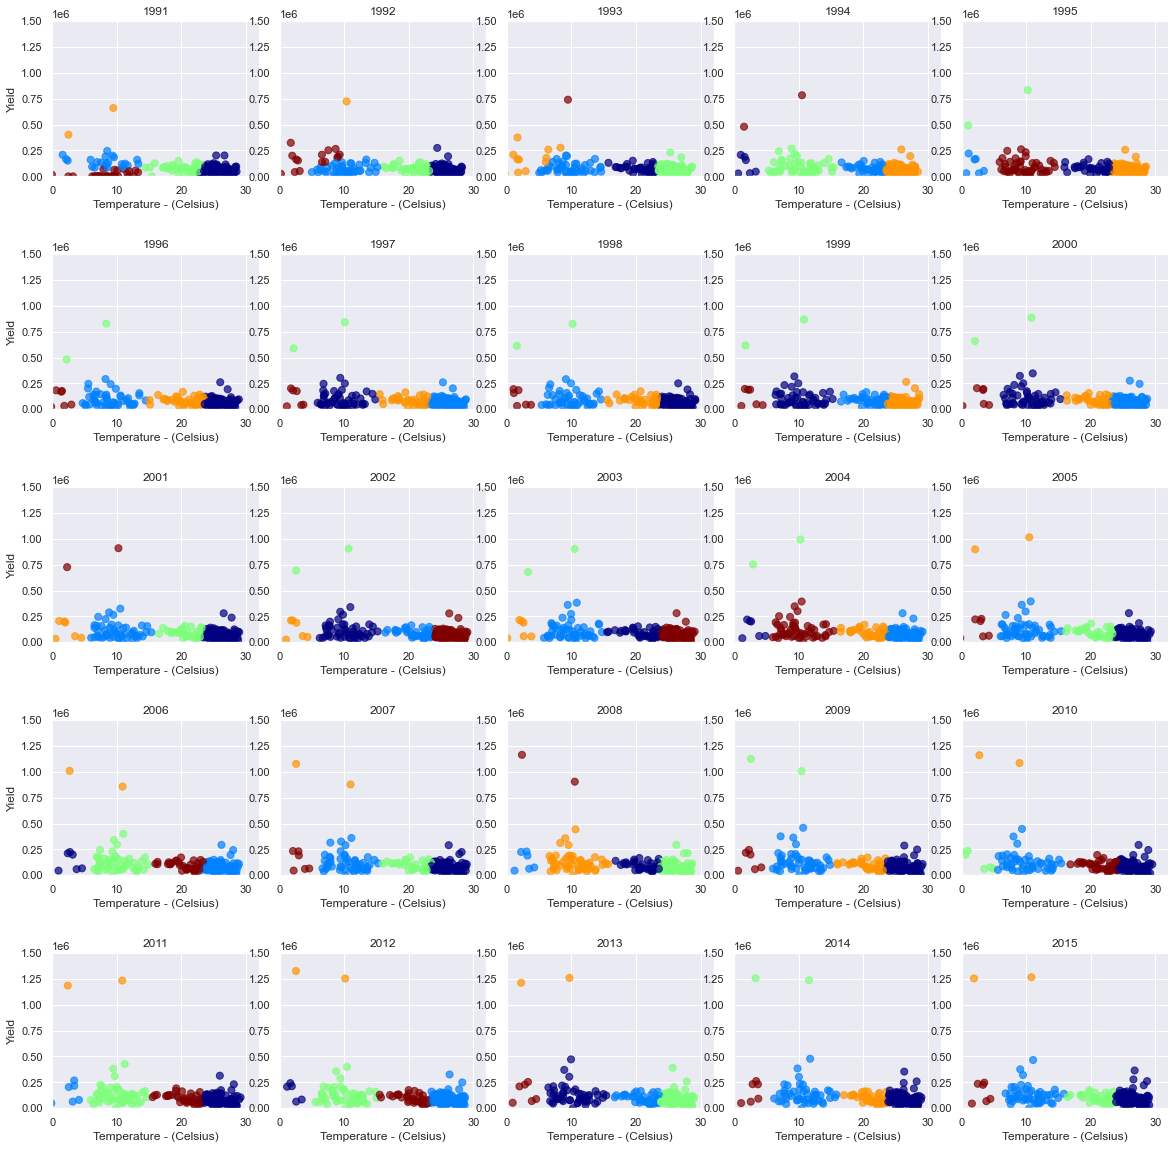

In [266]:
fig, axes = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

grid_combos = []
for i in range(5):
    for j in range(5):
        grid_combos.append((i, j))
        
# from the years 1991 to 2016
years = [year for year in range(1991, 2016)]
        
for i, year in enumerate(years):
    # taking country yield and temperature for this year
    year_filter = (yield_and_climate['Year'] == year)
    yield_and_temperature = yield_and_climate.loc[year_filter, ['Year', 'Area', 'Yield', 'Temperature - (Celsius)']]

    # scaling the numerical values
    scaler = preprocessing.MinMaxScaler() # min-max normalizer
    X = yield_and_temperature[['Yield', 'Temperature - (Celsius)']] # numeric values only
    X_scaled = X.copy()
    X_scaled[['Yield', 'Temperature - (Celsius)']] = scaler.fit_transform(X) # scaling numerics
    
    # kmeans clustering
    model = KMeans(5, verbose=0) # fitting for 5 clusters
    model.fit(X_scaled)
    X_scaled['kmeans'] = model.labels_
    kmeans_labels = pd.Series(model.labels_)
    v1 = X['Temperature - (Celsius)']
    v2 = X['Yield']

    # drawing scatterplot for this year
    row, col = grid_combos[i]
    axes[row, col].scatter(v1, v2, c=kmeans_labels, s=50,cmap='jet',alpha=0.7)
    axes[row, col].set_title(year)
    axes[row, col].set(xlim=(0, 32))
    axes[row, col].set(ylim=(0, 1.5e6))
    axes[row, col].set_xlabel(v1.name)
    
    if (col % 5 == 0):
        axes[row, col].set_ylabel(v2.name)
    else:
        axes[row, col].set_ylabel('')


In [188]:
# studying the clusters of 2016...
for g in range(0,5):  
    print(f'Group {g}:\n')
    print(yield_and_temperature.loc[(X_scaled['kmeans'] == g), 'Area'])
    print()

Group 0:

4536                                          Afghanistan
4537                                              Albania
4541                                            Argentina
4542                                              Armenia
4544                                              Austria
4545                                           Azerbaijan
4550                                              Belarus
4551                                              Belgium
4554                                               Bhutan
4556                               Bosnia and Herzegovina
4560                                             Bulgaria
4569                                                Chile
4570                                                China
4575                                              Croatia
4578                                              Czechia
4581                                              Denmark
4590                                              Estonia
4593

## Average yield vs Total rainfall, finding clusters of countries for each year

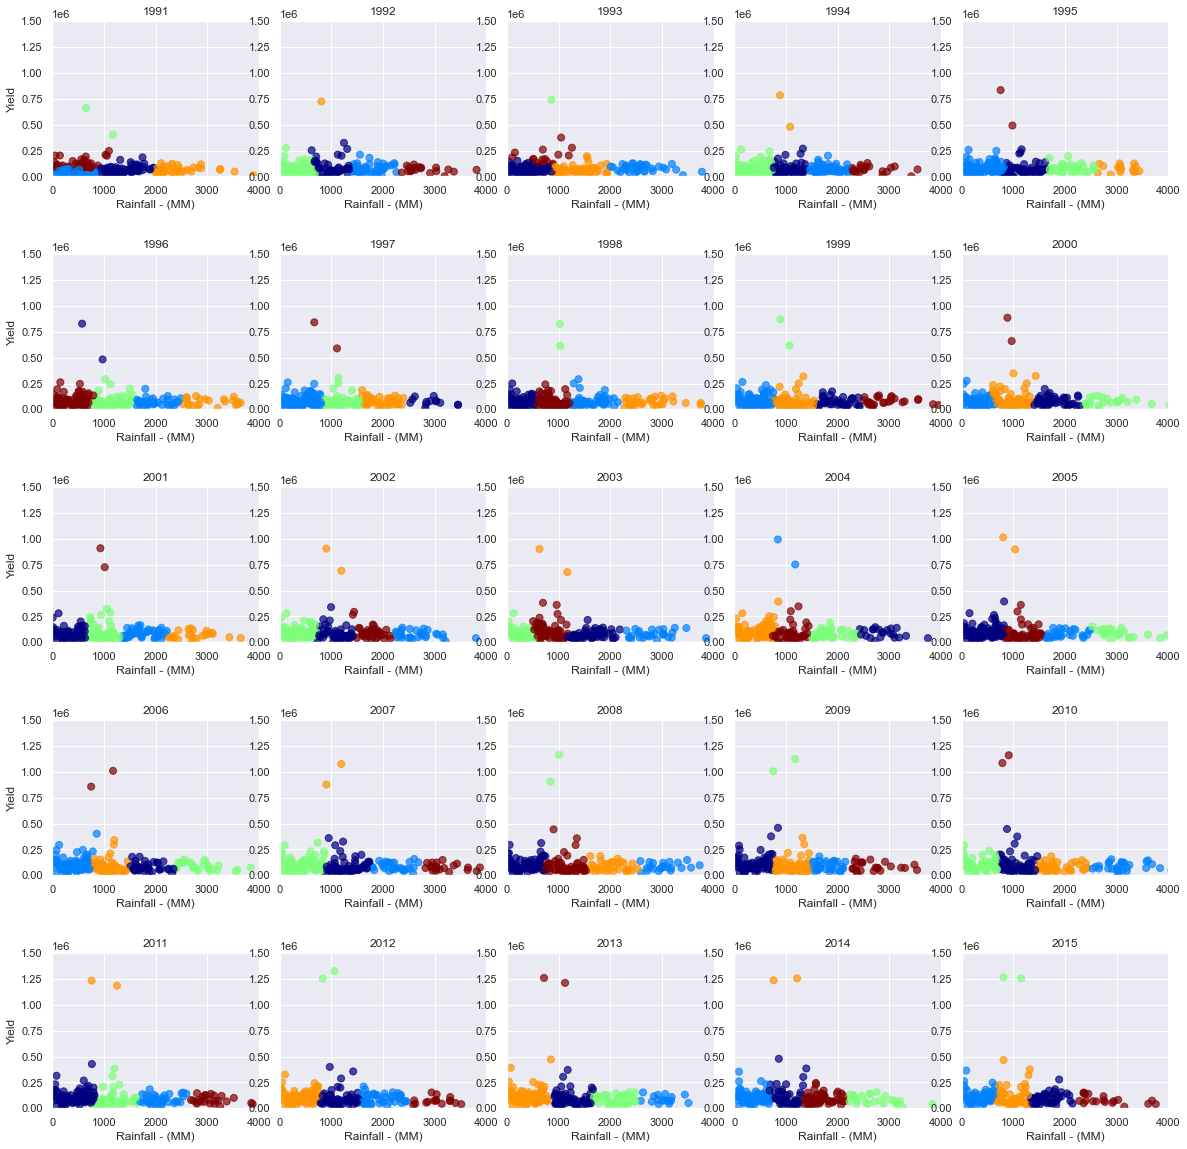

In [267]:
fig, axes = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

grid_combos = []
for i in range(5):
    for j in range(5):
        grid_combos.append((i, j))
        
# from the years 1991 to 2016
years = [year for year in range(1991, 2016)]
        
for i, year in enumerate(years):
    # taking country yield and rainfall for this year
    year_filter = (yield_and_climate['Year'] == year)
    yield_and_rainfall = yield_and_climate.loc[year_filter, ['Year', 'Area', 'Yield', 'Rainfall - (MM)']]

    # scaling the numerical values
    scaler = preprocessing.MinMaxScaler() # min-max normalizer
    X = yield_and_rainfall[['Yield', 'Rainfall - (MM)']] # numeric values only
    X_scaled = X.copy()
    X_scaled[['Yield', 'Rainfall - (MM)']] = scaler.fit_transform(X) # scaling numerics
    
    # kmeans clustering
    model = KMeans(5, verbose=0) # fitting for 5 clusters
    model.fit(X_scaled)
    X_scaled['kmeans'] = model.labels_
    kmeans_labels = pd.Series(model.labels_)
    v1 = X['Rainfall - (MM)']
    v2 = X['Yield']

    # drawing scatterplot for this year
    row, col = grid_combos[i]
    axes[row, col].scatter(v1, v2, c=kmeans_labels, s=50,cmap='jet',alpha=0.7)
    axes[row, col].set_title(year)
    axes[row, col].set(xlim=(0, 4e3))
    axes[row, col].set(ylim=(0, 1.5e6))
    axes[row, col].set_xlabel(v1.name)
    
    if (col % 5 == 0):
        axes[row, col].set_ylabel(v2.name)
    else:
        axes[row, col].set_ylabel('')

The factors that impact crop growth are mainly rainfall and temperature. We have this data, so is it possible to train a regression model for future predictions? Let's see.

## Per Country Correlations

### Crops Overall

In [65]:
rawMeltedYield

,Year,Area,Yield
0,1961,Afghanistan,40287.91667
1,1961,Africa,45553.50993
2,1961,Albania,15242.56944
3,1961,Algeria,31470.05556
4,1961,American Samoa,19846.12000
...,...,...,...
14843,2018,World,93636.97674
14844,2018,Yemen,60869.95455
14845,2018,Yugoslav SFR,0.00000
14846,2018,Zambia,82033.07692


### Area harvested melted...

In [277]:
areaHarvestedMelted = areaHarv_melted
# rawMeltedProduction = prod_melted.groupby(['Year', 'Area'])['Production'].sum().reset_index()

<ipython-input-279-bea7d07d65b9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countryharvested['Year'] = countryharvested['Year'].astype(str)


<AxesSubplot:xlabel='Country'>

<Figure size 2160x1440 with 0 Axes>

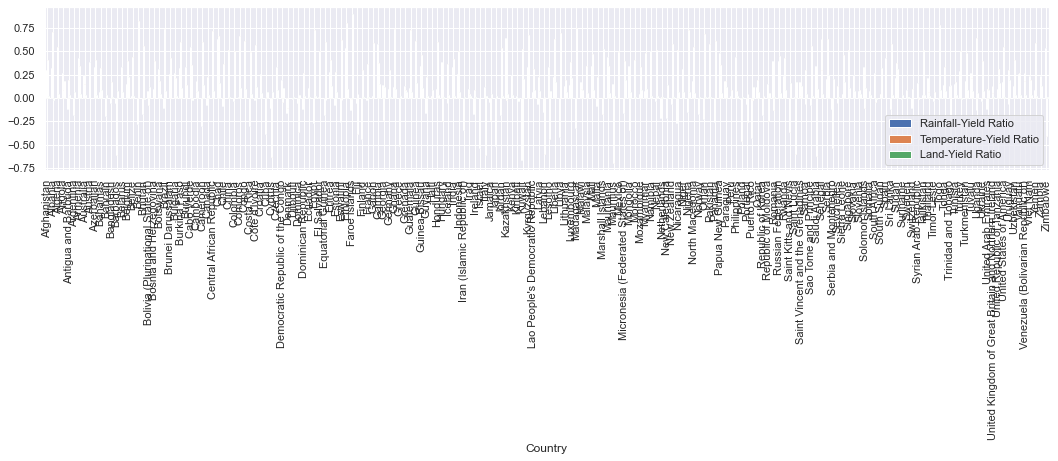

In [279]:
countriesOfInterest = all_countries['0']
countriesMeetingThreshold = []

for country in countriesOfInterest:
    countryyield = rawMeltedProduction[rawMeltedProduction['Area'] == country]
    countryclimate = climate_melted[climate_melted['Area'] == country]
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    countryharvested['Year'] = countryharvested['Year'].astype(str)
    
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged['Year'] = countrymerged['Year'].astype(str)
    
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner')
    countrymerged.drop(columns=['index'], inplace=True, errors='ignore')
    corr = countrymerged.corr()
    countriesMeetingThreshold.append([country, corr.iloc[1,0], corr.iloc[2,0], corr.iloc[3,0]])    

countriesMeetingThreshold = pd.DataFrame(countriesMeetingThreshold, columns=['Country', 'Rainfall-Yield Ratio', 'Temperature-Yield Ratio', 'Land-Yield Ratio'])
countriesMeetingThreshold.dropna(inplace=True)
countriesMeetingThreshold.sort_values(by='Temperature-Yield Ratio', ascending=False)
countriesMeetingThreshold.set_index('Country', inplace=True)
plt.figure(figsize=(30,20))
countriesMeetingThreshold.plot.bar()

In [63]:
countriesMeetingThreshold.sort_values(by=['Rainfall-Yield Ratio', 'Temperature-Yield Ratio'], ascending=False)

,Rainfall-Yield Ratio,Temperature-Yield Ratio,Land-Yield Ratio
Country,,,
Kazakhstan,0.64033,-0.01688,0.79885
Senegal,0.63108,0.29820,0.75300
Chad,0.62795,0.66383,0.97013
Gambia,0.57422,0.37300,0.92996
Cabo Verde,0.54320,0.35776,-0.47339
...,...,...,...
Puerto Rico,-0.42423,-0.02074,0.84714
Finland,-0.44327,0.29588,0.48619
Japan,-0.51607,-0.33572,0.90741


### Only Caffeine-Based Crops

In [41]:
caffeineMelted = crops_clean[np.logical_and(crops_clean['Element'] == 'Production', crops_clean['Item'].str.contains('Coffee|Tea|Kola'))].melt(id_vars=['Area'], value_vars=crops_clean.columns[3:],
                              var_name='Year', value_name='Production')
caffeineMelted = caffeineMelted.groupby(['Year', 'Area'])['Production'].mean().reset_index()

<ipython-input-72-5547f7c051fa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countryyield['Year'] = countryyield['Year'].astype(str)
<ipython-input-72-5547f7c051fa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countryclimate['Year'] = countryclimate['Year'].astype(str)


<AxesSubplot:xlabel='Country'>

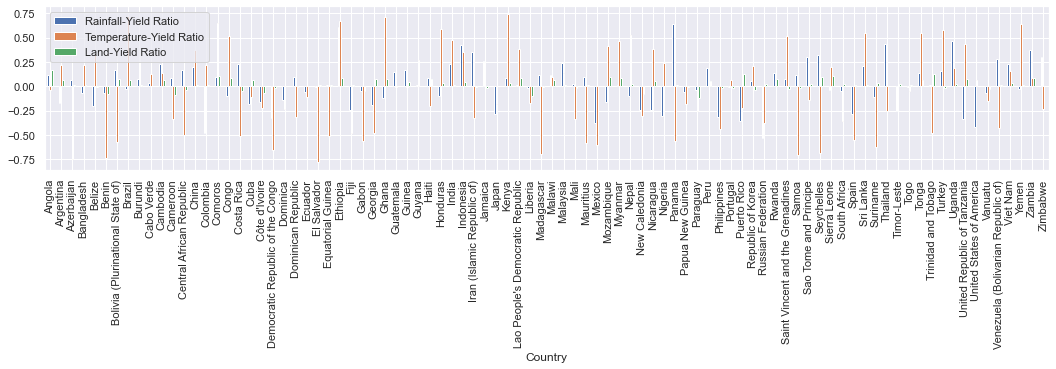

In [72]:
countriesOfInterest = caffeineMelted['Area'].unique()
countriesMeetingThreshold = []
tempCorr = pd.DataFrame()

# countryclimate = climate_melted[climate_melted['Area'] == country]
# countryclimate['Year']
climate_melted['Year'] = climate_melted['Year'].astype(str)

for country in countriesOfInterest:
    countryyield = caffeineMelted[caffeineMelted['Area'] == country]
    countryyield['Year'] = countryyield['Year'].astype(str)
    countryclimate = climate_melted[climate_melted['Area'] == country]
    countryclimate['Year'] = countryclimate['Year'].astype(str)
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner')

    countrymerged.drop(columns=['index'], inplace=True, errors='ignore')
    corr = countrymerged.corr()
    tempCorr = corr
    countriesMeetingThreshold.append([country, corr.iloc[1,0], corr.iloc[2,0], corr.iloc[3, 0]])    

countriesMeetingThreshold = pd.DataFrame(countriesMeetingThreshold, columns=['Country', 'Rainfall-Yield Ratio', 'Temperature-Yield Ratio', 'Land-Yield Ratio'])
countriesMeetingThreshold.dropna(inplace=True)
countriesMeetingThreshold.sort_values(by='Temperature-Yield Ratio', ascending=False)
countriesMeetingThreshold.set_index('Country', inplace=True)
countriesMeetingThreshold.plot.bar()

In [66]:
countriesMeetingThreshold.sort_values(by=['Rainfall-Yield Ratio', 'Temperature-Yield Ratio', 'Land-Yield Ratio'], ascending=False)

,Rainfall-Yield Ratio,Temperature-Yield Ratio,Land-Yield Ratio
Country,,,
Panama,0.63850,-0.56605,0.45652
Ethiopia,0.60962,0.66471,0.81977
Uganda,0.46825,0.18672,0.27858
Thailand,0.43433,-0.25099,0.39571
Indonesia,0.42013,0.35253,0.69449
...,...,...,...
Puerto Rico,-0.35210,-0.21944,0.93136
Mexico,-0.37841,-0.60408,-0.04308
United States of America,-0.41738,0.06258,0.38615


# Future Predictions

## Overall Crop Yields

### Linear Regression for Overall

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [68]:
metric = 'Production'

In [69]:
countriesToTest = ['Kazakhstan', 'Republic of Korea', 'Namibia', 'Russia', 'Liberia', 'Somalia', 'Guinea-Bissau', 'India']

In [70]:
linearmodels = {}
linear_scalers = {}

for country in countriesToTest:
    #prep indiv. data
    countryyield = rawMeltedProduction[rawMeltedProduction['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    #merge
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner') 
    countrymerged[metric] = countrymerged[metric].astype(int)
    if('index' in countrymerged.columns):
        countrymerged.drop(columns=['index'], inplace=True)
    if(len(countrymerged != 0)):
        countrymerged['Year'] = countrymerged['Year'].astype(int)
        y = countrymerged[metric].values
        X = countrymerged.drop(['Year', 'Area', metric], axis=1).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)

        reg_test = LinearRegression()
        reg_test.fit(X_train, y_train)

        X_test = min_max_scaler.transform(X_test)

        y_pred = reg_test.predict(X_test)
        print("R^2: {} for {}".format(reg_test.score(X_test, y_test), country))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error: {} for {}".format(rmse, country), end='\n\n')
        linearmodels[country] = reg_test
        linear_scalers[country] = min_max_scaler

R^2: 0.8698616047138001 for Kazakhstan
Root Mean Squared Error: 7369730.319999321 for Kazakhstan

R^2: -0.15353808048356532 for Republic of Korea
Root Mean Squared Error: 2752320.7817258267 for Republic of Korea

R^2: 0.6095101908161369 for Namibia
Root Mean Squared Error: 144103.59662678873 for Namibia

R^2: 0.891601572928114 for Liberia
Root Mean Squared Error: 183017.73075294675 for Liberia

R^2: 0.3829055721487691 for Somalia
Root Mean Squared Error: 142075.63510610478 for Somalia

R^2: 0.6014795694422059 for Guinea-Bissau
Root Mean Squared Error: 136925.2750042707 for Guinea-Bissau

R^2: -6.366086512520551 for India
Root Mean Squared Error: 734441239.05466 for India



### Polynomial Regression for Overall

In [71]:
polyregmodels = {}
polyfitters = {}
scalers = {}

for country in countriesToTest:
    countryyield = rawMeltedProduction[rawMeltedProduction['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner')
    if('index' in countrymerged.columns):
        countrymerged.drop(columns=['index'], inplace=True)
    if(len(countrymerged != 0)):
        countrymerged['Year'] = countrymerged['Year'].astype(int)
        y = countrymerged[metric].values
        X = countrymerged.drop(['Year', 'Area', metric], axis=1).values
        poly = PolynomialFeatures(degree=2)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state=42)
        reg_test = LinearRegression()

        min_max_scaler = preprocessing.MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)

        reg_test.fit(X_train, y_train)
        X_test = min_max_scaler.transform(X_test)

        y_pred = reg_test.predict(X_test)

        print("R^2: {} for {}".format(reg_test.score(X_test, y_test), country))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error: {} for {}".format(rmse, country))

        polyregmodels[country] = reg_test
        polyfitters[country] = poly
        scalers[country] = min_max_scaler

R^2: -21.783622572659706 for Kazakhstan
Root Mean Squared Error: 97512493.33797733 for Kazakhstan
R^2: 0.6076512490158422 for Republic of Korea
Root Mean Squared Error: 1605163.288754667 for Republic of Korea
R^2: -3.9273885929918118 for Namibia
Root Mean Squared Error: 511892.0385789767 for Namibia
R^2: 0.8489251754221445 for Liberia
Root Mean Squared Error: 216061.66840374927 for Liberia
R^2: 0.10222380883264504 for Somalia
Root Mean Squared Error: 171367.25318661306 for Somalia
R^2: -0.25148698017286053 for Guinea-Bissau
Root Mean Squared Error: 242645.08254921561 for Guinea-Bissau
R^2: 0.8174549849482357 for India
Root Mean Squared Error: 115617516.369751 for India


## Caffeine Crop Yields

### Linear Regression for Caffeine Crops

In [72]:
caffeineProdCountries = ['Angola', 'Argentina', 'Azerbaijan', 'Bangladesh', 'Belize',
       'Benin', 'Bolivia (Plurinational State of)', 'Brazil', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic',
       'China', 'China, mainland', 'China, Taiwan Province of',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       "Côte d'Ivoire", 'Cuba', 'Democratic Republic of the Congo',
       'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador',
       'Equatorial Guinea', 'Ethiopia', 'Ethiopia PDR', 'Fiji',
       'French Polynesia', 'Gabon', 'Georgia', 'Ghana', 'Guadeloupe',
       'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'India',
       'Indonesia', 'Iran (Islamic Republic of)', 'Jamaica', 'Japan',
       'Kenya', "Lao People's Democratic Republic", 'Liberia',
       'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Martinique',
       'Mauritius', 'Mexico', 'Montenegro', 'Mozambique', 'Myanmar',
       'Nepal', 'New Caledonia', 'Nicaragua', 'Nigeria', 'Panama',
       'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Portugal',
       'Puerto Rico', 'Republic of Korea', 'Réunion', 'Russia', 'Rwanda',
       'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa',
       'Sao Tome and Principe', 'Saudi Arabia', 'Seychelles',
       'Sierra Leone', 'South Africa', 'Sri Lanka', 'Suriname',
       'Thailand', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago',
       'Turkey', 'Uganda', 'United Republic of Tanzania', 'United States',
       'USSR', 'Vanuatu', 'Venezuela (Bolivarian Republic of)',
       'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe', 'World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Southern Africa',
       'Western Africa', 'Americas', 'Northern America',
       'Central America', 'Caribbean', 'South America']

In [73]:
cafflinearmodels = {}
cafflinear_scalers = {}

for country in caffeineProdCountries:
    #prep indiv. data
    countryyield = caffeineMelted[caffeineMelted['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    #merge
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner')    
    if('index' in countrymerged.columns):
        countrymerged.drop(columns=['index'], inplace=True)
    if(len(countrymerged != 0)):
        countrymerged['Year'] = countrymerged['Year'].astype(int)
        y = countrymerged[metric].values
        X = countrymerged.drop(['Year', 'Area', metric], axis=1).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)

        reg_test = LinearRegression()
        reg_test.fit(X_train, y_train)

        X_test = min_max_scaler.transform(X_test)

        y_pred = reg_test.predict(X_test)
        print("R^2: {} for {}".format(reg_test.score(X_test, y_test), country))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error: {} for {}".format(rmse, country))
        cafflinearmodels[country] = reg_test
        cafflinear_scalers[country] = min_max_scaler

R^2: 0.5141247247527013 for Angola
Root Mean Squared Error: 3140.505113143233 for Angola
R^2: 0.7806578428393615 for Argentina
Root Mean Squared Error: 6105.239530350282 for Argentina
R^2: 0.5883448873991491 for Azerbaijan
Root Mean Squared Error: 4598.234100613623 for Azerbaijan
R^2: 0.25071272078934503 for Bangladesh
Root Mean Squared Error: 6228.684579708189 for Bangladesh
R^2: -0.20432964823498745 for Belize
Root Mean Squared Error: 96.11734731652692 for Belize
R^2: 0.32218813665656343 for Benin
Root Mean Squared Error: 16.68557985704199 for Benin
R^2: 0.54758928037866 for Bolivia (Plurinational State of)
Root Mean Squared Error: 1726.4890361673506 for Bolivia (Plurinational State of)
R^2: 0.42807816124036047 for Brazil
Root Mean Squared Error: 185175.3324404656 for Brazil
R^2: -0.15309367345519842 for Burundi
Root Mean Squared Error: 40892.196132722915 for Burundi
R^2: -0.25716942032635415 for Cabo Verde
Root Mean Squared Error: 19.108352715920738 for Cabo Verde
R^2: 0.53661720042

R^2: -0.13644506246963028 for Zambia
Root Mean Squared Error: 1009.1310314033507 for Zambia
R^2: -0.16890509420542577 for Zimbabwe
Root Mean Squared Error: 2654.738276597365 for Zimbabwe


In [74]:
caffpolyregmodels = {}
caffpolyfitters = {}
caffscalers = {}

for country in caffeineProdCountries:
    countryyield = caffeineMelted[caffeineMelted['Area'] == country]
    countryclimate = rainfallAndTemperatures[rainfallAndTemperatures['Area'] == country]
    countryharvested = areaHarvestedMelted[areaHarvestedMelted['Area'] == country]
    countrymerged = pd.merge(countryyield, countryclimate, on=["Year", "Area"], how='inner')
    countrymerged = countrymerged.merge(countryharvested, on=['Year', 'Area'], how='inner')
    if('index' in countrymerged.columns):
        countrymerged.drop(columns=['index'], inplace=True)
    
    if(len(countrymerged != 0)):
        countrymerged['Year'] = countrymerged['Year'].astype(int)
        y = countrymerged[metric].values
        X = countrymerged.drop(['Year', 'Area', metric], axis=1).values
        poly = PolynomialFeatures(degree=2)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state=42)
        reg_test = LinearRegression()

        min_max_scaler = preprocessing.MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)

        reg_test.fit(X_train, y_train)
        X_test = min_max_scaler.transform(X_test)

        y_pred = reg_test.predict(X_test)

        print("R^2: {} for {}".format(reg_test.score(X_test, y_test), country))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error: {} for {}".format(rmse, country))

        polyregmodels[country] = reg_test
        polyfitters[country] = poly
        scalers[country] = min_max_scaler

R^2: 0.17386810833132482 for Angola
Root Mean Squared Error: 4095.0744226330394 for Angola
R^2: 0.5201113984790664 for Argentina
Root Mean Squared Error: 9030.501511628241 for Argentina
R^2: -1101.2573549822846 for Azerbaijan
Root Mean Squared Error: 237939.10506110912 for Azerbaijan
R^2: 0.06799793364338569 for Bangladesh
Root Mean Squared Error: 6946.732834830735 for Bangladesh
R^2: 0.24791892771485624 for Belize
Root Mean Squared Error: 75.95588301354029 for Belize
R^2: -1.1885246735072954 for Benin
Root Mean Squared Error: 29.982127354786144 for Benin
R^2: 0.8305748882699118 for Bolivia (Plurinational State of)
Root Mean Squared Error: 1056.5407977365965 for Bolivia (Plurinational State of)
R^2: 0.3424884969599843 for Brazil
Root Mean Squared Error: 198548.43599747203 for Brazil
R^2: -0.0707487764253345 for Burundi
Root Mean Squared Error: 39405.054623906006 for Burundi
R^2: -1.5254816411345575 for Cabo Verde
Root Mean Squared Error: 27.083104957648747 for Cabo Verde
R^2: 0.5444607

## Making Predictions

## 2018, 2019, 2020 predictions for Kazakhstan

91027543.51716453


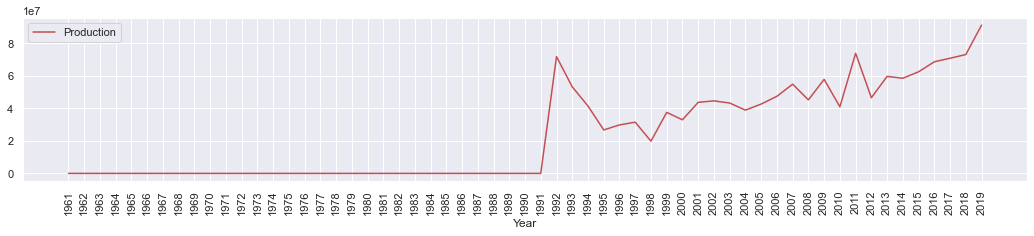

In [75]:
kazakh = linearmodels['Kazakhstan']
#Kazakhstan's total rainfall, average temperature and area harvested
X = [[320, 30, 11413941]]
pred2019 = kazakh.predict(linear_scalers['Kazakhstan'].transform(X))
print(pred2019[0])
rawMeltedProduction = rawMeltedProduction.append({'Year': 2019, 'Area': 'Kazakhstan', 'Production': pred2019[0]}, ignore_index=True)
kazakh = rawMeltedProduction[rawMeltedProduction['Area'] == 'Kazakhstan']
kazakh = kazakh.set_index('Year')
kazakh.plot(color='r')
plt.xticks(range(len(kazakh.index)), kazakh.index, rotation=90)
plt.show()

2663076.9708257522


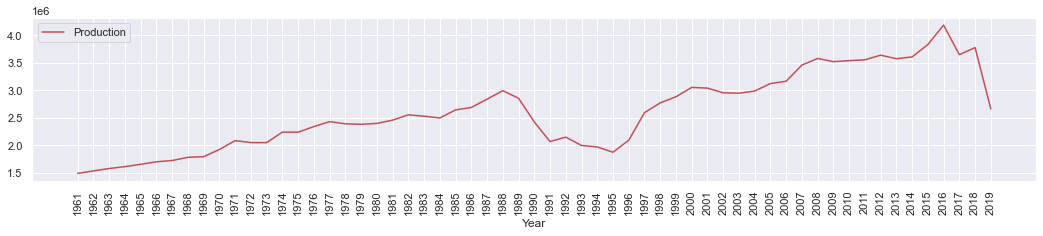

In [76]:
korea = linearmodels['Liberia']
#Kazakhstan's total rainfall, average temperature and area harvested
X = [[3000.79150, 30.17398, 1279954]]
pred2019 = korea.predict(linear_scalers['Liberia'].transform(X))
print(pred2019[0])
rawMeltedProduction = rawMeltedProduction.append({'Year': 2019, 'Area': 'Liberia', 'Production': pred2019[0]}, ignore_index=True)
koreaY = rawMeltedProduction[rawMeltedProduction['Area'] == 'Liberia']
koreaY = koreaY.set_index('Year')
koreaY.plot(color='r')
plt.xticks(range(len(koreaY.index)), koreaY.index, rotation=90)
plt.show()